# k-means clustering and data reduction via non-negative matrix factorization (NMF) via OpenMSI.

Using the OpenMSI API, a peak cube is requested for a dataset.  Once the peak cube is a `NumPy` array, it can be analyzed with a variety of `SciPy` or `scikit` algorithms.  In this notebook, we first cluster the pixels using k-means with a Euclidean distance function.  Some of the clusters clearly represent background mass spectra, consisting solely of MALDI matrix ions.  Thus, from the clusters, we create a "mask" that removes pixels near and beyond the edge of the sample which are contaminated with background ions.  From this masked data, we perform data reduction using the non-negative matrix factorization technique.  The NMF decomposition approximates the spatial and spectral variation in ion intensity using using two matrices which together are far smaller than the original data set.

## Preliminaries: loading required libraries and setting `matplotlib` variables for pretty plotting

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
import requests, json
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid


In [2]:
plt.rcParams['pdf.fonttype']=42
# plt.rcParams['pdf.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 2 # set the value globally

## Fetching a derived data set -- an OpenMSI analysis
Here the data set we fetch is _derived_ from a raw OpenMSI datacube.  Peaks in the m/z dimension were previously identified and _peak_ intensities at each pixel are stored online in a *peak*cube.  These derived data are called "analyses" in OpenMSI.  The `anaIndex` below choses which analysis to pull from the OpenMSI server.  

For the publicly available mouse brain dataset, the available analyses can be viewed by logging into OpenMSI, choosing "Files", and then clicking on the filename corresponding to the dataset.  Two analyses are available for '20120711_Brain.h5'.  The first, with index 0, represents the peakcube.  (The second, with index 1 and not used here, represents a separate on-server NMF analysis.)

In [3]:
client = requests.Session()
filename = '20120711_Brain.h5'
dataIndex = '0'
expIndex = '0'

In [4]:
anaIndex = 0
expIndex = 0
payload = {'file':filename,
              'expIndex':expIndex,'anaIndex':anaIndex,
              'anaDataName':'peak_cube','format':'JSON'}
url = 'https://openmsi.nersc.gov/openmsi/qcube'
r = client.get(url,params=payload)
peakCube = np.asarray(json.loads(r.text))
print peakCube.shape

(122, 120, 697)


In [5]:
anaIndex = 0
expIndex = 0
payload = {'file':filename,
              'expIndex':expIndex,'anaIndex':anaIndex,
              'anaDataName':'peak_mz','format':'JSON'}
url = 'https://openmsi.nersc.gov/openmsi/qcube'
r = client.get(url,params=payload)
peakCubeIons = np.asarray(json.loads(r.text))
print peakCubeIons.shape

(697,)


In [6]:
Nx = peakCube.shape[0]
Ny = peakCube.shape[1]
Nz = peakCube.shape[2]
temp = np.amax(peakCube,2)
data = np.divide(peakCube,temp[:,:,np.newaxis])
data = peakCube.reshape(Nx*Ny,Nz)

## Perform k-means clustering to identify 12 clusters of pixels. 

The clustering is a method to group pixels that have similar spectra.

In [7]:
from scipy.cluster.vq import kmeans, vq
centers, _ = kmeans(data, 12, iter=20)
cluster, _ = vq(data, centers)

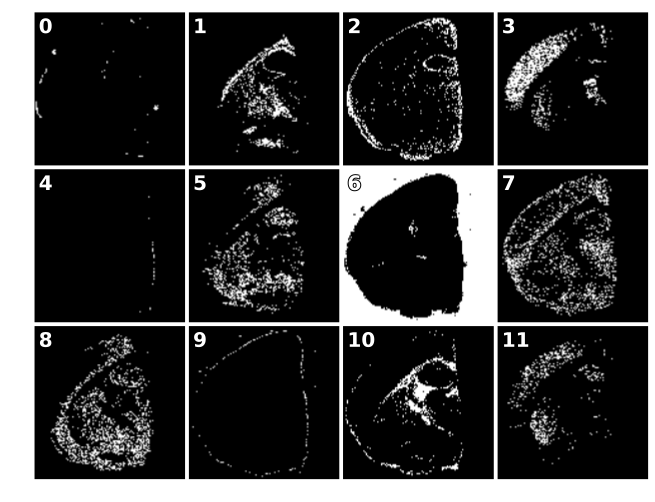

In [14]:
import matplotlib.patheffects as PathEffects
fig = plt.figure(1, (11, 11))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (3, 4), # creates 3x4 grid of axes
                axes_pad=0.05, # pad between axes in inches.
                )

for i in range(12):
    grid[i].imshow(cluster.reshape(Nx, Ny)==i, cmap='gray') # The AxesGrid object work as a list of axes.
    grid[i].axis('off')
    grid[i].text(3, 16, str(i), fontsize=20, color='white', weight='bold',
                 path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")])


By visual inspection of the plot above, most clusters appear to show ions that appear in the background or only at the edges of the sample.  These are likely to be artifacts.  The code block below defines the _good_ (i.e. not edge- or background clusters) and masks out the remaining clusters.

**NOTE**: The numbering of k-means clusters is arbitrary; there is no default ordering.  Every time k-means runs, identified clusters may be returned with different indices.  Thus if you are running this notebook yourself, you will need to manually change `idxBad` below to point to cluster you wish to exclude from the downstream analysis.

### Masking out "edge" and background clusters

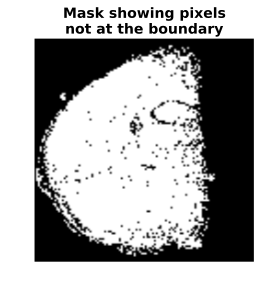

In [15]:
idxBad = [2, 4, 6, 9]
badMask = np.zeros((Nx, Ny))

rules = []
for i in idxBad:
    temp = cluster.reshape(Nx,Ny)==i
    rules.append(temp)

    badMask = rules[0]
for rule in rules[1:]:
    badMask = np.logical_or(badMask,rule)
badMask = badMask==False

plt.imshow(badMask,cmap='gray')
plt.axis('off')
plt.title('Mask showing pixels\nnot at the boundary',fontsize=14,color='black',weight='bold')
plt.show()

In [10]:
msidata = peakCube[:]
msidata = np.multiply(msidata, badMask[:,:,np.newaxis])

originalShape = msidata.shape
numBins   = msidata.shape[-1]
numPixels = msidata.size / numBins #The last data dimension is assumed to contain the spectra
msidata = msidata.reshape(numPixels, numBins).transpose()

# Factor the matrix using non-negative matrix factorization

The matrix `msidata` will be factored into two matrices, $W$ and $H$.

In [16]:
from sklearn.decomposition import ProjectedGradientNMF
nmf_model = ProjectedGradientNMF(n_components = 3, init='random', random_state=0)
W = nmf_model.fit_transform(msidata);
H = nmf_model.components_;


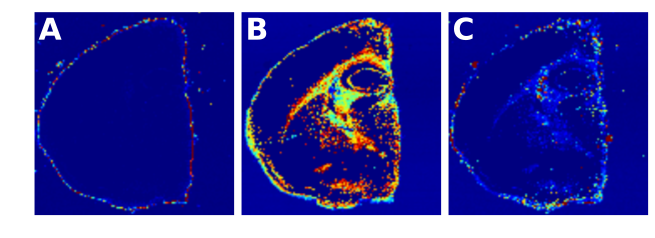

In [17]:
# print model.components_.shape
from skimage import exposure

nmfdata = H.reshape(3,Nx,Ny)
fig = plt.figure(1, (11., 11.))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (1, 3), # creates 2x2 grid of axes
                axes_pad=0.1, # pad between axes in inch.
                )

for i in range(3):
    img = nmfdata[i,:,:]
    p2, p98 = np.percentile(img, (1, 99))
    img_eq = exposure.rescale_intensity(img, in_range=(p2, p98))
    grid[i].imshow(img_eq) # The AxesGrid object work as a list of axes.
    grid[i].axis('off')
    grid[i].text(2,16,chr(i+65),fontsize=30,color='white',weight='bold')
fig.savefig('Figure_4_nmf_images.pdf')

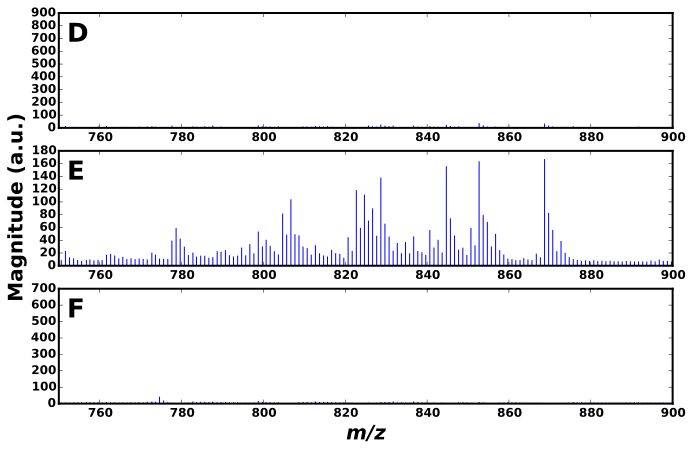

In [13]:
fig = plt.figure(1, (11.,7.))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.stem(peakCubeIons, W[:,i], markerfmt=" ")
    plt.xlim([750, 900])
    plt.text(plt.axis()[0]+2,plt.axis()[3]*0.75,chr(i+65+3),fontsize=26,color='black',weight='bold')
    if i==1:
        plt.ylabel('Magnitude (a.u.)',fontsize=20,weight='bold')


plt.xlabel('m/z',fontsize=20,weight='bold',style='italic')
fig.savefig('Figure_4_nmf_spectra.pdf')